In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import os 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [4]:
from basin_volume import *

/home/adam/.conda/envs/jax311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import gc
from tqdm import tqdm

# Pythia

In [31]:
cfg = VolumeConfig(model_type="pythia", 
                   model_name="31m",
                   tol=5,
                   y_tol=50,
                   val_size=10,
                   n_samples=1,
                   )

ve = VolumeEstimator.from_config(cfg)


In [ ]:
np.log2(ve.config.checkpoint_step)

np.float64(17.125655621440476)

In [19]:
ve.config.n_samples = 10
result = ve.run()

In [20]:
result.estimates.shape

(10,)

In [21]:
RESULTS = {
    "naive": result,
}


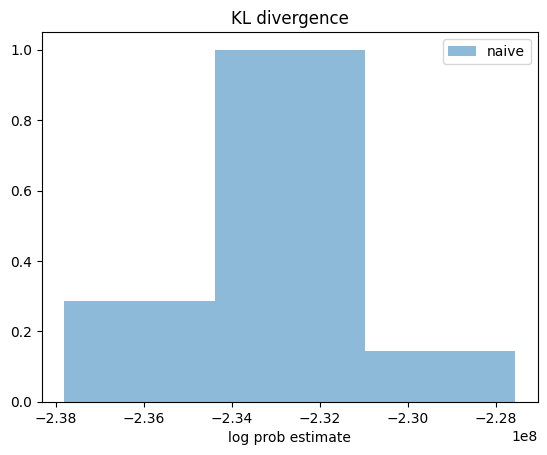

In [26]:
settings = {'alpha': 0.5, 'fill': True}

for label, results in RESULTS.items():
    these_settings = dict(settings, label=label)
    scaled_histogram(results.estimates, label, these_settings)
plt.xlabel("log prob estimate")
plt.legend()
plt.title("KL divergence")
plt.show()

## Checkpoint step scan

In [33]:
cfg = VolumeConfig(model_type="pythia", 
                   model_name="31m",
                   tol=5,
                   y_tol=50,
                   val_size=10,
                   n_samples=10,
                   )

In [80]:
get_pythia_checkpoint_steps("31m")

[0,
 1,
 2,
 4,
 8,
 16,
 32,
 64,
 128,
 256,
 512,
 1000,
 2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 9000,
 10000,
 11000,
 12000,
 13000,
 14000,
 15000,
 16000,
 17000,
 18000,
 19000,
 20000,
 21000,
 22000,
 23000,
 24000,
 25000,
 26000,
 27000,
 28000,
 29000,
 30000,
 31000,
 32000,
 33000,
 34000,
 35000,
 36000,
 37000,
 38000,
 39000,
 40000,
 41000,
 42000,
 43000,
 44000,
 45000,
 46000,
 47000,
 48000,
 49000,
 50000,
 51000,
 52000,
 53000,
 54000,
 55000,
 56000,
 57000,
 58000,
 59000,
 60000,
 61000,
 62000,
 63000,
 64000,
 65000,
 66000,
 67000,
 68000,
 69000,
 70000,
 71000,
 72000,
 73000,
 74000,
 75000,
 76000,
 77000,
 78000,
 79000,
 80000,
 81000,
 82000,
 83000,
 84000,
 85000,
 86000,
 87000,
 88000,
 89000,
 90000,
 91000,
 92000,
 93000,
 94000,
 95000,
 96000,
 97000,
 98000,
 99000,
 100000,
 101000,
 102000,
 103000,
 104000,
 105000,
 106000,
 107000,
 108000,
 109000,
 110000,
 111000,
 112000,
 113000,
 114000,
 115000,
 116000,
 117000,
 1

In [35]:
all_steps = get_pythia_checkpoint_steps("31m")
last_step = all_steps[-1]
steps_to_scan = [2**i for i in range(18)] + [last_step]
# closest existing step to each power of 2
steps_to_scan = [min(all_steps, key=lambda x: abs(x - step)) for step in steps_to_scan]

print(steps_to_scan)

results = {}

for step in steps_to_scan:
    cfg.checkpoint_step = step
    ve = VolumeEstimator.from_config(cfg)
    ve.config.n_samples = 10
    result = ve.run()
    results[step] = result
    print(step, result.estimates.max())


[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1000, 2000, 4000, 8000, 16000, 33000, 66000, 131000, 143000]
1 -85272290.0
2 -85272290.0
4 -85272290.0
8 -85272100.0
16 -84438620.0
32 -75301944.0
64 -63608650.0
128 -61697304.0
256 -87780160.0
512 -109886370.0
1000 -123102620.0
2000 -127199710.0
4000 -137671840.0
8000 -140793810.0
16000 -147044140.0
33000 -201693980.0
66000 -378581570.0


2025-01-27 22:35:34.479584: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.92GiB (rounded to 2060451840)requested by op 
2025-01-27 22:35:34.479831: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] **********************************************__*************************************************___
E0127 22:35:34.479868 1434703 pjrt_stream_executor_client.cc:3045] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2060451840 bytes. [tf-allocator-allocation-error='']


ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2060451840 bytes.

In [39]:
for step in steps_to_scan:
    if step in results:
        continue
    # Clear memory before each iteration
    gc.collect()
    jax.clear_caches()
    
    cfg.checkpoint_step = step
    ve = VolumeEstimator.from_config(cfg)
    result = ve.run()
    results[step] = result
    print(step, result.estimates.max())
    
    # Explicitly delete the estimator
    del ve
    gc.collect()

131000 -852937200.0
143000 -879291200.0


In [40]:
import pickle


In [42]:
# save results
with open("../results/31m_checkpoint_scan.pkl", "wb") as f:
    pickle.dump(results, f)

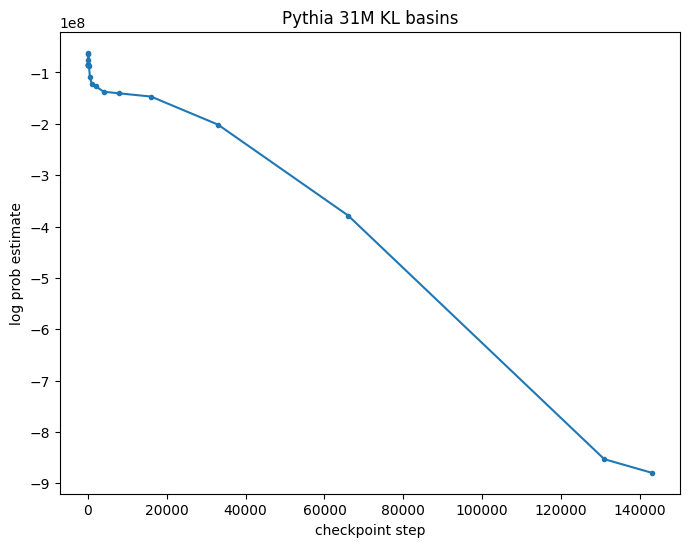

In [45]:
# plot against checkpoint step
plt.figure(figsize=(8, 6))
maxes = [result.estimates.max() for result in results.values()]
plt.plot(list(results.keys()), maxes, '.-')
plt.xlabel("checkpoint step")
plt.ylabel("log prob estimate")
#plt.xscale("log")
plt.title("Pythia 31M KL basins")
plt.show()

## Cutoff scan

In [46]:
cfg = VolumeConfig(model_type="pythia", 
                   model_name="31m",
                   tol=5,
                   y_tol=50,
                   val_size=10,
                   n_samples=10,
                   )                   

In [53]:
cutoffs = np.array(logspace(1e-5, 1e3, 9))
cutoff_results = {}

In [54]:

gc.collect()
jax.clear_caches()
ve = VolumeEstimator.from_config(cfg)

for cutoff in cutoffs:
    if cutoff in cutoff_results:
        continue
    # we can reuse the same estimator
    
    ve.config.cutoff = cutoff
    result = ve.run()
    cutoff_results[cutoff] = result
    print(cutoff, result.estimates.max())

# Explicitly delete the estimator
del ve
gc.collect()

1.0000011e-05 -339241060.0
0.000100000114 -302792580.0
0.0010000011 -268629200.0
0.010000005 -227555780.0
0.10000005 -190301260.0
1.0000006 -148840600.0
10.000003 -108098550.0
100.0 -45488416.0
1000.0 -15238272.0


1487

In [55]:
with open("../results/31m_cutoff_scan.pkl", "wb") as f:
    pickle.dump(cutoff_results, f)

In [60]:
pythia_31m_model = load_pythia_checkpoint("143000", "31m")
model_dim = torch.nn.utils.parameters_to_vector(pythia_31m_model.parameters()).shape[0]


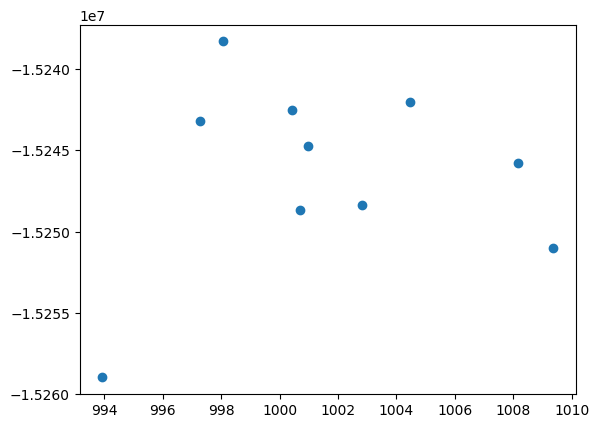

In [75]:
idx = -1
plt.scatter(cutoff_results[cutoffs[idx]].deltas, cutoff_results[cutoffs[idx]].estimates)
plt.show()

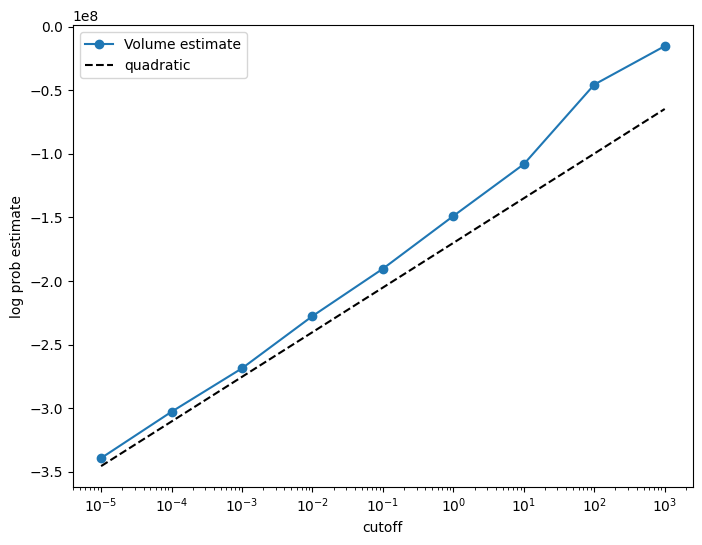

In [68]:
plt.figure(figsize=(8, 6))
maxes = [result.estimates.max() for result in cutoff_results.values()]
plt.plot(list(cutoff_results.keys()), maxes, 'o-', label="Volume estimate")
plt.xlabel("cutoff")
plt.ylabel("log prob estimate")
plt.xscale("log")
# line with slope model_dim/2
plt.plot(list(cutoff_results.keys()), 
         [model_dim/2 * np.log(cutoff) - 1.7e8 for cutoff in cutoff_results.keys()], 
         '--', color="black", 
         label="quadratic")
plt.legend()
plt.show()

## Adam eps scan


In [8]:
cfg = VolumeConfig(model_type="pythia", 
                   model_name="31m",
                   tol=5,
                   y_tol=50,
                   val_size=10,
                   n_samples=10,
                   preconditioner_type="adam",
                   )                   

In [18]:
epsilons = np.array(logspace(1e-9, 1e-1, 9))
eps_results = {}

In [19]:
gc.collect()
jax.clear_caches()
ve = VolumeEstimator.from_config(cfg)

for epsilon in tqdm(epsilons):
    if epsilon in eps_results:
        continue
    # we can reuse the same estimator
    
    ve.config.preconditioner_eps = epsilon
    ve.set_preconditioner()
    result = ve.run()
    eps_results[epsilon] = result
    print(epsilon, result.estimates.max())

# Explicitly delete the estimator
del ve
gc.collect()

Matching parameters in group 0
Matching parameters in group 1


 11%|█         | 1/9 [00:18<02:30, 18.83s/it]

1e-09 -300521100.0


 22%|██▏       | 2/9 [00:31<01:46, 15.25s/it]

1e-08 -230734830.0


 33%|███▎      | 3/9 [00:42<01:20, 13.38s/it]

1e-07 -210085730.0


 44%|████▍     | 4/9 [00:53<01:01, 12.34s/it]

1e-06 -191198080.0


 56%|█████▌    | 5/9 [01:02<00:44, 11.16s/it]

1e-05 -182548700.0


 67%|██████▋   | 6/9 [01:11<00:31, 10.50s/it]

0.000100000005 -187688100.0


 78%|███████▊  | 7/9 [01:21<00:20, 10.10s/it]

0.001 -199505070.0


 89%|████████▉ | 8/9 [01:29<00:09,  9.50s/it]

0.01 -212583280.0


100%|██████████| 9/9 [01:36<00:00, 10.77s/it]

0.10000002 -223964030.0


1532

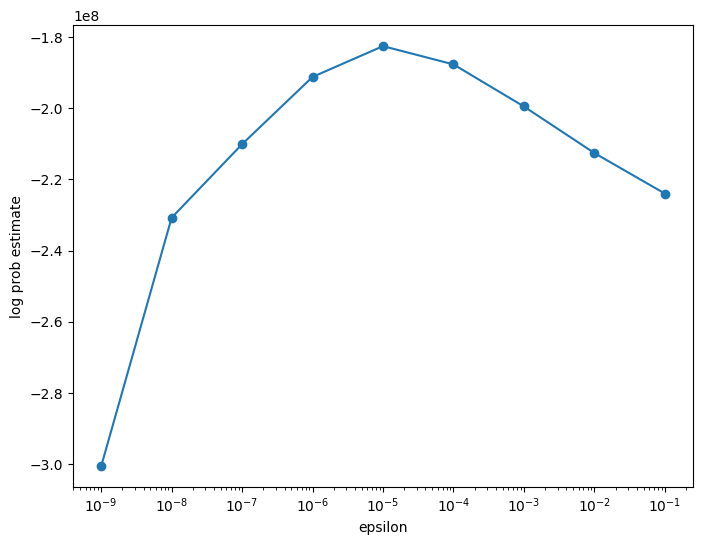

In [20]:
# plot
plt.figure(figsize=(8, 6))
maxes = [result.estimates.max() for result in eps_results.values()]
plt.plot(list(eps_results.keys()), maxes, 'o-', label="Volume estimate")
plt.xlabel("epsilon")
plt.ylabel("log prob estimate")
plt.xscale("log")
plt.show()


In [42]:
# early checkpoint
cfg = VolumeConfig(model_type="pythia", 
                   model_name="31m",
                   tol=5,
                   y_tol=50,
                   val_size=10,
                   n_samples=100,
                   checkpoint_step=1000,
                   preconditioner_type="adam",
                   )

init_eps_results = {}


In [43]:
gc.collect()
jax.clear_caches()
ve = VolumeEstimator.from_config(cfg)

for epsilon in tqdm(epsilons):
    if epsilon in init_eps_results:
        continue
    # we can reuse the same estimator
    
    ve.config.preconditioner_eps = epsilon
    ve.set_preconditioner()
    result = ve.run()
    init_eps_results[epsilon] = result
    print(epsilon, result.estimates.max())

# Explicitly delete the estimator
del ve
gc.collect()

Matching parameters in group 0
Matching parameters in group 1


 11%|█         | 1/9 [02:03<16:31, 123.90s/it]

1e-09 -223350270.0


 22%|██▏       | 2/9 [03:47<13:01, 111.71s/it]

1e-08 -162765380.0


 33%|███▎      | 3/9 [05:47<11:33, 115.59s/it]

1e-07 -94159560.0


 44%|████▍     | 4/9 [07:35<09:24, 112.82s/it]

1e-06 -79495740.0


 56%|█████▌    | 5/9 [09:31<07:36, 114.00s/it]

1e-05 -79137240.0


 67%|██████▋   | 6/9 [11:29<05:46, 115.36s/it]

0.000100000005 -67737290.0


 78%|███████▊  | 7/9 [13:20<03:47, 113.94s/it]

0.001 -104527240.0


 89%|████████▉ | 8/9 [14:47<01:45, 105.33s/it]

0.01 -113831224.0


100%|██████████| 9/9 [16:25<00:00, 109.51s/it]

0.10000002 -119171784.0


1595

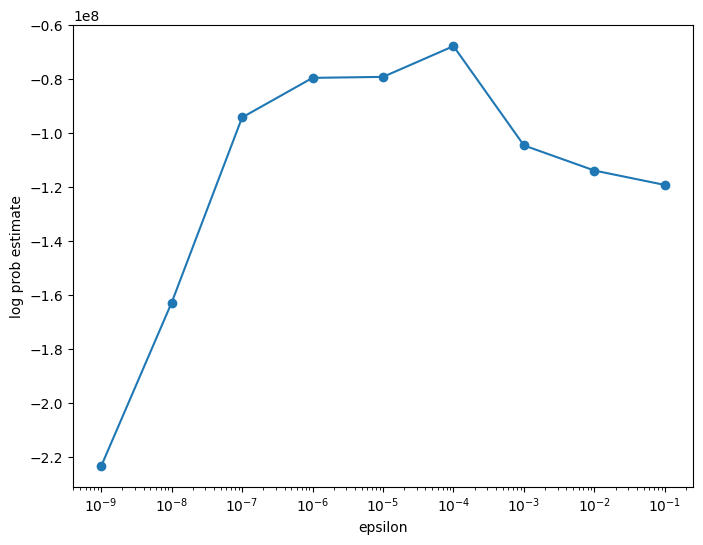

In [44]:
# plot
plt.figure(figsize=(8, 6))
maxes = [result.estimates.max() for result in init_eps_results.values()]
plt.plot(list(init_eps_results.keys()), maxes, 'o-', label="Volume estimate")
plt.xlabel("epsilon")
plt.ylabel("log prob estimate")
plt.xscale("log")
plt.show()


### low cutoff

In [7]:
# low cutoff
cfg = VolumeConfig(model_type="pythia", 
                   model_name="31m",
                   tol=5,
                   y_tol=50,
                   val_size=20,
                   n_samples=10,
                   cutoff=1e-6,
                   preconditioner_type="adam",
                   )

low_cutoff_results = {}
epsilons = np.array(logspace(1e-9, 1e-1, 9))



In [8]:
gc.collect()
jax.clear_caches()
ve = VolumeEstimator.from_config(cfg)

for epsilon in tqdm(epsilons):
    if epsilon in init_eps_results:
        continue
    # we can reuse the same estimator
    
    ve.config.preconditioner_eps = epsilon
    ve.set_preconditioner()
    result = ve.run()
    init_eps_results[epsilon] = result
    print(epsilon, result.estimates.max())

# Explicitly delete the estimator
del ve
gc.collect()

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


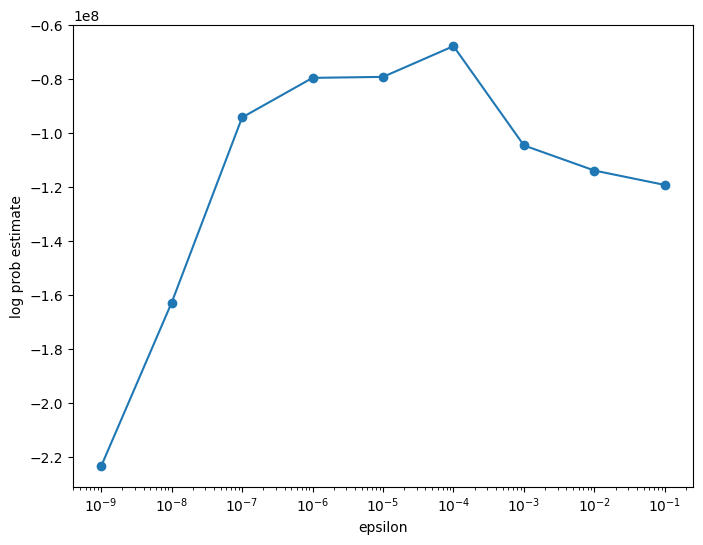

In [ ]:
# plot
plt.figure(figsize=(8, 6))
maxes = [result.estimates.max() for result in init_eps_results.values()]
plt.plot(list(init_eps_results.keys()), maxes, 'o-', label="Volume estimate")
plt.xlabel("epsilon")
plt.ylabel("log prob estimate")
plt.xscale("log")
plt.show()


# ConvNext

In [6]:
cfg = bv.VolumeConfig(model_type="convnext", 
                   tol=2,
                   y_tol=20,
                   n_samples=10,
                   )
ve = bv.VolumeEstimator.from_config(cfg)
result = ve.run()
result.estimates.max()

Array(-10245624., dtype=float32)

In [5]:
cfg = bv.VolumeConfig(model_type="convnext", 
                   tol=2,
                   y_tol=20,
                   n_samples=10,
                   preconditioner_type="adam",
                   )
ve = bv.VolumeEstimator.from_config(cfg)
result = ve.run()
result.estimates.max()

/mnt/ssd-1/adam/basin-volume/src/basin_volume/convnext.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(f)


Array(-6729126., dtype=float32)